A lot of recommender systems are built on matrix factorization models, where the partially observed matrix of user/item interactions is approximated by a product of matrices encoding latent characteristics of users and items. They can be corrected by user and item bias terms, and modified by activation functions that map to the data type of the observed interactions (e.g. binary kudos on Strava activities, counts of visits of a YouTube channel, ratings on Tripadvisor, or time spent watching a TikTok video before swiping up).

In machine learning, these matrix factorizations are often implemented as embeddings into latent spaces followed by scalar products of the user latent vectors by the item latent vectors, and the model is fit to historical data with a gradient descent algorithm. A [Keras tutorial on collaborative filtering](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) describes the methodology with the Movielens dataset.

While the resulting model only provides point estimates of future interactions between users and items, a Bayesian treatment of the problem would add an approximation of the uncertainty of these estimates. Formally, we could express the same model with priors on the vector embeddings in a probabilistic programming library and sample the posteriors with an MCMC algorithm, but computing the likelihood of past interactions can be impractical for very large datasets. Moreover, due to the invariance of the model under permutations of the embedding dimensions, MCMC sampling of the multimodal posterior would be a nightmare. On the other hand, minimizing $KL(q \Vert p)$ through variational inference produces a mode-seeking behavior (see for instance these [lecture notes](https://www.fil.ion.ucl.ac.uk/~wpenny/talks/inference.pdf)), a bit like gradient descent in "classical" machine learning finds a local minimum.

In this blog post, we will be exploring how to implement a model inspired by Gopalan, Hofman and Blei ([Scalable Recommendation with Poisson Factorization](https://arxiv.org/abs/1311.1704)) with [TensorFLow Probability](https://www.tensorflow.org/probability).

In the mean field approximation, where we assume that the variational distribution $q$ factorizes over the latent variables, we can implement variational inference with probabilistic layers from the `tfp.layers` module. One way to do it is to specify the variational distribution $q$ with a `tfpl.DistributionLambda(lambda variational_parameter: ...)` layer and add its interaction with the prior in the [ELBO](https://en.wikipedia.org/wiki/Evidence_lower_bound) through an activity regularizer, `activity_regularizer = tfpl.KLDivergenceRegularizer(prior_distribution)`. For probabilistic embeddings, the variational parameters are conveniently expressed as standard embeddings into a space of dimension $n_{params} \times D$, where $D$ is the dimension of the original latent embeddings, and $n_{params}$ the number of variational parameters of the corresponding component of $q$.

In [1]:
#| include: false
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
tdb = tfp.bijectors
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
#| include: false

#the following two cells are recycled from the keras tutorial

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = tfk.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
#| include: false

#process the data
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

In [4]:
#| include: false

#split the training and validation data
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Rescale the ratings to integer counts between 0 and 9 and cast as float for
# compatibility with the log_prob method of the tfd.Poisson distribution
y = (2*df['rating']-1).astype('float').values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

A [custom Keras layer](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) wraps the construction of a probabilistic embedding, with its `__init__` method receiving the hyperparameters. Here we picked Gamma distributions for both the priors and the variational distributions.

In [5]:
class GammaEmbedding(tfkl.Layer):
    def __init__(self, num_classes, embedding_size,
                 embedding_concentration, embedding_rate, kl_weight=None, **kwargs):
        super(GammaEmbedding, self).__init__(**kwargs)
        
        self.embedding_parameters = tfkl.Embedding(
            num_classes,
            2 * embedding_size,
            embeddings_initializer="he_normal"
        )
        
        self.embedding_distribution = tfpl.DistributionLambda(
            lambda x: tfd.Independent(
                tfd.Gamma(tf.math.exp(x[:, :embedding_size]),
                          rate=tf.math.exp(x[:, embedding_size:])),
                reinterpreted_batch_ndims=1),
            activity_regularizer = tfpl.KLDivergenceRegularizer(
                tfd.Independent(
                    tfd.Gamma(embedding_concentration
                              * tf.ones(shape=(embedding_size,), dtype=tf.float32),
                              rate=embedding_rate),
                    reinterpreted_batch_ndims=1),
                weight=kl_weight,
                use_exact_kl=True
            )
        )
            
    def __call__(self, inputs):
        embedding_param = self.embedding_parameters(inputs)
        return self.embedding_distribution(embedding_param)

The bias terms mentioned earlier could be implemented as one-dimensional probabilistic embeddings and added to the scalar products of user and item embeddings, but Gopalan *et al.* suggest to introduce these degrees of freedom as hyperpriors for the rate parameters of the embedding Gamma distributions with a hierarchical model construction. Compared to the simple Gamma embedding where the priors in `tfpl.KLDivergenceRegularizer(prior, weight)` were fixed and specified as an `activity_regularizer` parameter, we now need them to evolve with the variational parameters of their hyperprior during training. As a workaround, we can specify a custom KL divergence loss term with the `add_loss` method.

In [6]:
class HierarchicalGammaEmbedding(tfkl.Layer):
    def __init__(self, num_classes, embedding_size,
                 parent_concentration, parent_rate,
                 embedding_concentration, kl_weight=None, **kwargs):
        super(HierarchicalGammaEmbedding, self).__init__(**kwargs)
        self.kl_weight = kl_weight
        self.embedding_concentration = embedding_concentration
        
        self.rate_dist_params = tfpl.VariableLayer((2*embedding_size,))
        self.rate_distribution = tfpl.DistributionLambda(
            lambda x: tfd.Independent(
                tfd.Gamma(tf.math.exp(x[:embedding_size]),
                          rate=tf.math.exp(x[embedding_size:])),
                reinterpreted_batch_ndims=1),
            activity_regularizer = tfpl.KLDivergenceRegularizer(
                tfd.Independent(
                    tfd.Gamma(parent_concentration
                              * tf.ones(shape=(embedding_size,), dtype=tf.float32),
                              rate=parent_rate),
                    reinterpreted_batch_ndims=1),
                weight=kl_weight,
                use_exact_kl=True
            )
        )
        
        self.embedding_parameters = tfkl.Embedding(
            num_classes,
            2 * embedding_size,
            embeddings_initializer="glorot_normal"
        )
        
        self.embedding_distribution = tfpl.DistributionLambda(
            lambda x: tfd.Independent(
                tfd.Gamma(tf.math.exp(x[:, :embedding_size]),
                          rate=tf.math.exp(x[:, embedding_size:])),
                reinterpreted_batch_ndims=1
            )
        )
            
    def __call__(self, inputs):        
        embedding_param = self.embedding_parameters(inputs)
        embedding_distribution = self.embedding_distribution(embedding_param)

        rate_dist_params = self.rate_dist_params(inputs)
        embedding_rate = self.rate_distribution(rate_dist_params)
        embedding_prior = tfd.Independent(
            tfd.Gamma(self.embedding_concentration,
                      rate=embedding_rate * tf.ones((1, EMBEDDING_SIZE))),
            reinterpreted_batch_ndims=1)
        self.add_loss(
            self.kl_weight *
            tf.reduce_sum(embedding_distribution.kl_divergence(embedding_prior))
        )
        
        return embedding_distribution

With the probabilistic embeddings defined as custom layers, the full model only needs a few lines of code. The user and movie embeddings are constructed as hierarchical Gamma embeddings, and their scalar product will be the rate of the Poisson distribution that generates the observations, implemented as a distribution lambda layer.

In [7]:
class ProbabilisticRecommender(tfk.Model):
    def __init__(self, num_users, num_movies, embedding_size, kl_weight, **kwargs):
        super(ProbabilisticRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = HierarchicalGammaEmbedding(
            num_users,
            embedding_size,
            parent_concentration=1.,
            parent_rate=100.,
            embedding_concentration=1.,
            kl_weight=kl_weight
        )
        
        self.movie_embedding = HierarchicalGammaEmbedding(
            num_movies,
            embedding_size,
            parent_concentration=1.,
            parent_rate=100.,
            embedding_concentration=1.,
            kl_weight=kl_weight
        )

        self.head = tfpl.DistributionLambda(lambda t: tfd.Poisson(t))
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=-1)
        return self.head(dot_user_movie)

With a probability distribution as an output, this model requires a negative log-likelihood loss function, otherwise it is straightforward to train it like any Keras model.

In [8]:
EMBEDDING_SIZE = 50

BATCH_SIZE = 128
KL_WEIGHT =  1/x_train.shape[0]

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

prob_model = ProbabilisticRecommender(num_users, num_movies, EMBEDDING_SIZE, KL_WEIGHT)
prob_model.compile(
    loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=0.001)
)

In [9]:
#| include: false

history = prob_model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/15
709/709 [==============================] - 10s 10ms/step - loss: 22.4395 - val_loss: 15.1178
Epoch 2/15
709/709 [==============================] - 7s 10ms/step - loss: 11.1923 - val_loss: 8.6141
Epoch 3/15
709/709 [==============================] - 7s 9ms/step - loss: 6.8173 - val_loss: 5.7850
Epoch 4/15
709/709 [==============================] - 7s 10ms/step - loss: 4.8240 - val_loss: 4.3640
Epoch 5/15
709/709 [==============================] - 7s 10ms/step - loss: 3.8497 - val_loss: 3.6554
Epoch 6/15
709/709 [==============================] - 7s 9ms/step - loss: 3.3461 - val_loss: 3.2997
Epoch 7/15
709/709 [==============================] - 7s 10ms/step - loss: 3.0869 - val_loss: 3.0864
Epoch 8/15
709/709 [==============================] - 7s 9ms/step - loss: 2.9223 - val_loss: 2.9411
Epoch 9/15
709/709 [==============================] - 7s 9ms/step - loss: 2.8208 - val_loss: 2.8457
Epoch 10/15
709/709 [==============================] - 6s 9ms/step - loss: 2.7450 - val_los

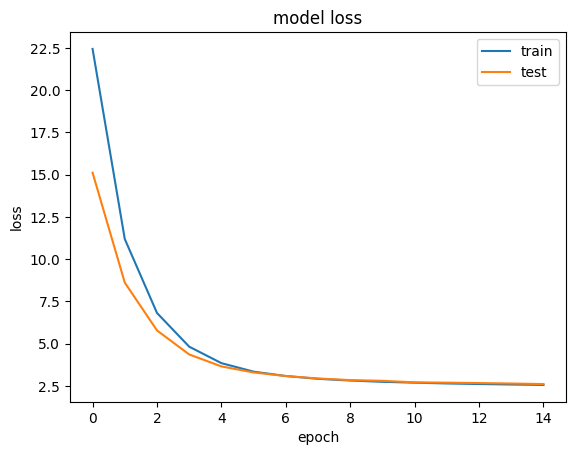

In [10]:
#| include: false

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [11]:
#| include: false

dist = prob_model(x_val[:3])
print(dist.mean())
print(dist.rate_parameter())

tf.Tensor([2.0382528 5.5400205 3.6636052], shape=(3,), dtype=float32)
tf.Tensor([2.0382528 5.5400205 3.6636052], shape=(3,), dtype=float32)


Once the model has been trained, we can call it on new user/item pairs to produce a Poisson distribution of posterior predicted observations. We can directly sample user ratings from this distribution with `.sample()`, or call its `.rate_parameter()` method to find the posterior predicted rate. The latter offers a higher resolution to rank items for a given user (it is a continuous variable rather than an integer) and is therefore more practical for recommender systems.

When the model is called, each probabilistic layer returns a single sample from its learned variational distribution. To estimate the posterior predicted Poisson rate of a user/item interaction, one can call the model several times to obtain a sample. In real world applications, drawing a single Poisson rate or only a few of them rather than estimating the posterior mean to score an item might prove more useful as it offers a broader variety of suggestions to users whose tastes are less certain, namely with user embedding distributions of higher variance. It addresses the exploration-exploitation trade-off with a mechanism similar to [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) (see also this previous [blog post](https://ybarmaz.github.io/blog/posts/2021-02-09-contextual_bandits.html)).

In general, users who have provided less ratings or good ratings across a large spectrum of items will get less defined embeddings, and this approach will give them recommendations that explore the item landscape more broadly than for users with tighter embeddings. These users with better-known tastes will still get random suggestions relatively far from their usual preference, albeit less frequently than the users with less defined embeddings, but this is not something that happens with models based on classical embeddings, which always return the same results.

This mechanism is also interesting when acquiring new users who have not yet provided ratings. We can itialize their embeddings to match the priors, or learned distributions from similar users but with wider variance, and use this untrained model to draw recommendations that are compatible with our prior knowledge. When they start giving ratings, we can train the corresponding user embedding layers to incorporate the new knowledge, while freezing the item embedding layers for stability and increased speed.

With TensorFlow Probability layers, we can thus add a Bayesian flavor to more traditional recommender systems and address issues such as exploration-exploitation trade-offs or cold starts in a more principled way. From another angle, we can express probabilistic models such as matrix factorization models as Keras models and take advantage of the `tf.data.Dataset` API for batch training with potentially large datasets.

In [12]:
#| include: false

def get_posterior_score(x, n_sample=10, model=prob_model, threshold=6):
    posterior_sample = [model(x).mean() for _ in range(n_sample)]
    posterior_sample = tf.stack(posterior_sample, axis=1)
    mean_score = tf.reduce_mean(posterior_sample, axis=1)
    std_score = tf.math.reduce_std(posterior_sample, axis=1)
    
    chances_good = tf.reduce_mean(tf.cast(posterior_sample>threshold, tf.float32), axis=1)
    return mean_score, std_score, chances_good

In [13]:
#| include: false

movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
#ratings = np.mean(np.concatenate([prob_model.predict(user_movie_array) for _ in range(50)], axis=1), axis=1)
ms, ss, cg = get_posterior_score(user_movie_array, 50)
ratings = ms.numpy()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 307
Movies with high ratings from user
--------------------------------
Army of Darkness (1993) : Action|Adventure|Comedy|Fantasy|Horror
American History X (1998) : Crime|Drama
Shaun of the Dead (2004) : Comedy|Horror
Reign Over Me (2007) : Drama
WALL·E (2008) : Adventure|Animation|Children|Romance|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Barefoot Executive, The (1971) : Children|Comedy
All the Vermeers in New York (1990) : Comedy|Drama|Romance
Light Years (Gandahar) (1988) : Adventure|Animation|Fantasy|Sci-Fi
Americathon (1979) : Comedy|Sci-Fi
Jetée, La (1962) : Romance|Sci-Fi
Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933) : Comedy|Drama
Starter for 10 (2006) : Drama|Romance
Himizu (2011) : Children|Crime|Drama
Kidnapping, Caucasian Style (Kavkazskaya plennitsa) (1967) : Comedy|Romance
Dragon ball Z 04: Lord Slug (1991) : Animation|Children


label
0.0    5.663747
1.0    5.688386
2.0    5.507147
3.0    5.777765
4.0    5.686498
5.0    6.185878
6.0    6.472412
7.0    6.785916
8.0    7.192302
9.0    7.432914
Name: score, dtype: float32


<AxesSubplot:xlabel='label', ylabel='score'>

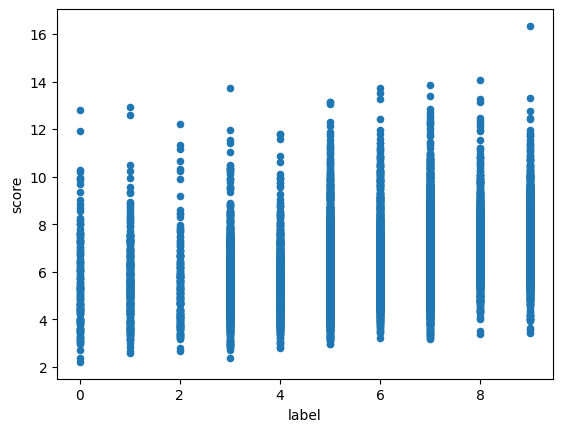

In [14]:
#| include: false

ms, ss, cg = get_posterior_score(x_val, 50)
df_result = pd.DataFrame({'label': y_val, 'score': ms, 'delta': ss, 'cg':cg})
df_result['rel_delta'] = df_result['delta'] / df_result['score']

print(df_result.groupby(['label'])['score'].mean())

df_result.plot.scatter('label', 'score')